### Introduction

This project focuses on analyzing and predicting health insurance premium amounts using a large, real-world dataset of nearly 50,000 policyholders. The dataset includes demographic attributes, socioeconomic factors, lifestyle indicators, medical history, and insurance plan details. The objective is two fold: first, to perform thorough exploratory data analysis (EDA) and data cleaning to ensure reliability; and second, to build and evaluate regression models that can accurately estimate annual premium amounts.

The analysis follows a structured data science workflow, including data preprocessing, outlier treatment, feature engineering, multicollinearity checks, and model comparison. Both traditional statistical models and machine learning approaches are explored to understand key premium drivers and improve predictive performance.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
# Loading the data
df= pd.read_excel('premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [3]:
# Number of rows and columns in the data
df.shape

(50000, 13)

In [4]:
# converting  all columns into consistent naming
df.columns = df.columns.str.replace(' ', '_' ).str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [5]:
# Checking information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    50000 non-null  int64 
 1   gender                 50000 non-null  object
 2   region                 50000 non-null  object
 3   marital_status         50000 non-null  object
 4   number_of_dependants   50000 non-null  int64 
 5   bmi_category           50000 non-null  object
 6   smoking_status         49989 non-null  object
 7   employment_status      49998 non-null  object
 8   income_level           49987 non-null  object
 9   income_lakhs           50000 non-null  int64 
 10  medical_history        50000 non-null  object
 11  insurance_plan         50000 non-null  object
 12  annual_premium_amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.0+ MB


The DataFrame has mixed type of data. 4 columns are of integer type and 9 are of object type. 

In [6]:
# Finding null values
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

Three columns have null values. 
The columns smoking_status, employment_status and income_level  contains  NaN values.

In [7]:
# Dropping the null values
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
# Finding duplicate values
df.duplicated().sum()

0

In [9]:
# Getting more information about the dataset
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


Age column has unexpected large age value even 356 years of age, which is preactically impossible, so that need to be addressed. 
number of dependants are having negative value, that need to be sorted out. 

In [10]:
# Getting info about number of dependants which are negative values
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [11]:
# Number of rows where number of dependants is less than zero
df[df.number_of_dependants<0].shape

(72, 13)

There are about 72 rows having number of dependants vlaue in negative.

In [12]:
# Changing negative values of dependants positive
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [13]:
# Getting more information about number of dependants
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

After removing the negative values, it is clear that number of dependants varies from 0 to 5

In [14]:
# finding the numerical columns
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

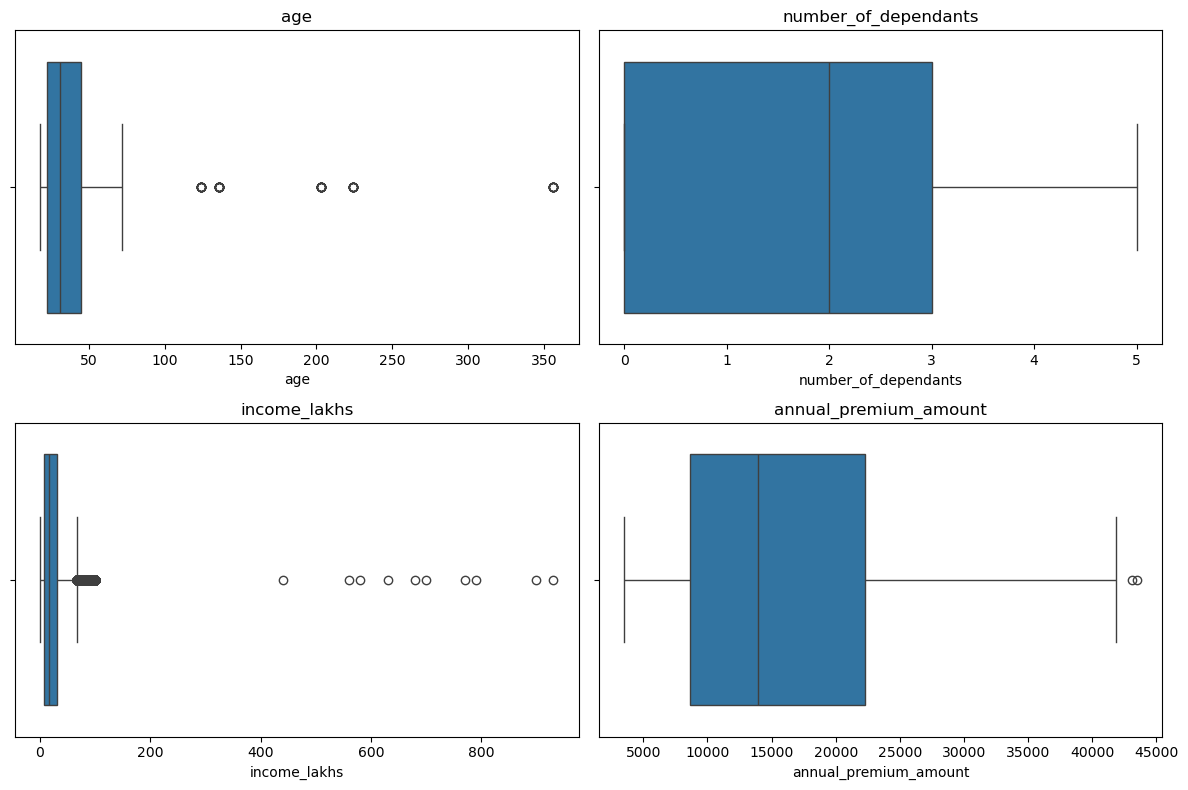

In [15]:
# Plotting the numerical column to check for outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes = axes.flatten()   # flatten so we can index easily

for ax, col in zip(axes, numeric_columns[:4]):   # take first 4 columns
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


The boxplots show that age, income, and annual premium have strong right-skewed distributions with several extreme outliers, especially unrealistic ages above 100. 

Number of dependents is more normally distributed with minor outliers. Overall, most variables need outlier treatment or transformation for reliable analysis.

In [16]:
# Finding the rows where age is greater than 100
df[df.age>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
114,224,Male,Northeast,Married,3,Normal,Regular,Salaried,25L - 40L,26,No Disease,Gold,27523
786,124,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,46,No Disease,Silver,11752
1298,124,Female,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,3,No Disease,Bronze,5311
1456,124,Female,Southwest,Unmarried,1,Overweight,No Smoking,Salaried,<10L,2,Diabetes,Bronze,10238
1470,136,Male,Southeast,Married,3,Overweight,Regular,Self-Employed,10L - 25L,15,High blood pressure,Gold,31913
1773,203,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,6,Diabetes,Bronze,8762
3658,136,Male,Southwest,Married,2,Normal,Regular,Salaried,10L - 25L,20,Diabetes & Thyroid,Gold,31402
4246,203,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,18,No Disease,Bronze,5254
5699,124,Female,Southeast,Unmarried,1,Normal,No Smoking,Self-Employed,25L - 40L,29,No Disease,Silver,10265
5951,136,Male,Southwest,Married,3,Underweight,Regular,Self-Employed,<10L,2,Heart disease,Silver,26127


In [17]:
# finding uniques values of age over 100
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [18]:
# Generating the dataset having age less or equal to 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

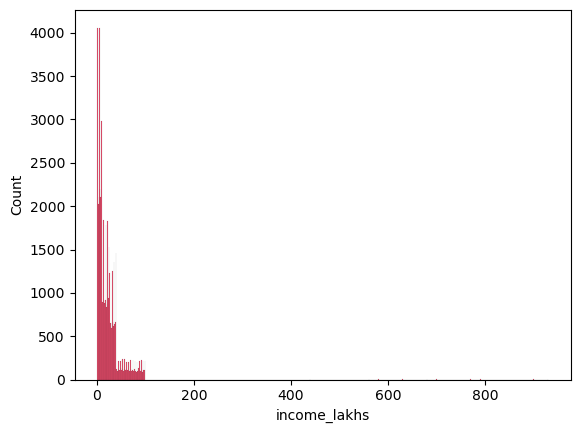

In [19]:
# plotting the income distribution
sns.histplot(df1.income_lakhs, color = 'crimson')

The histogram shows a highly right-skewed income distribution, where most individuals earn between 0–50 lakhs. A small number of extreme high-income values (up to 900+ lakhs) create a long right tail, compressing the main data to the left. This indicates the presence of significant outliers and large income inequality.

In [20]:
# Getting the quartile values for income
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [21]:
# getting upper bound and lower bound of income values
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 +1.5 * IQR
    return lower_bound, upper_bound

In [22]:
# Setting the income threshold
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [23]:
# Finding the rows where income is greater than threshold value
df1[df1.income_lakhs > quantile_threshold].shape

(10, 13)

In [24]:
# getting the dataset where income is less than the income threshold value
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(49908, 13)

In [25]:
# Getting information about the new dataset
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


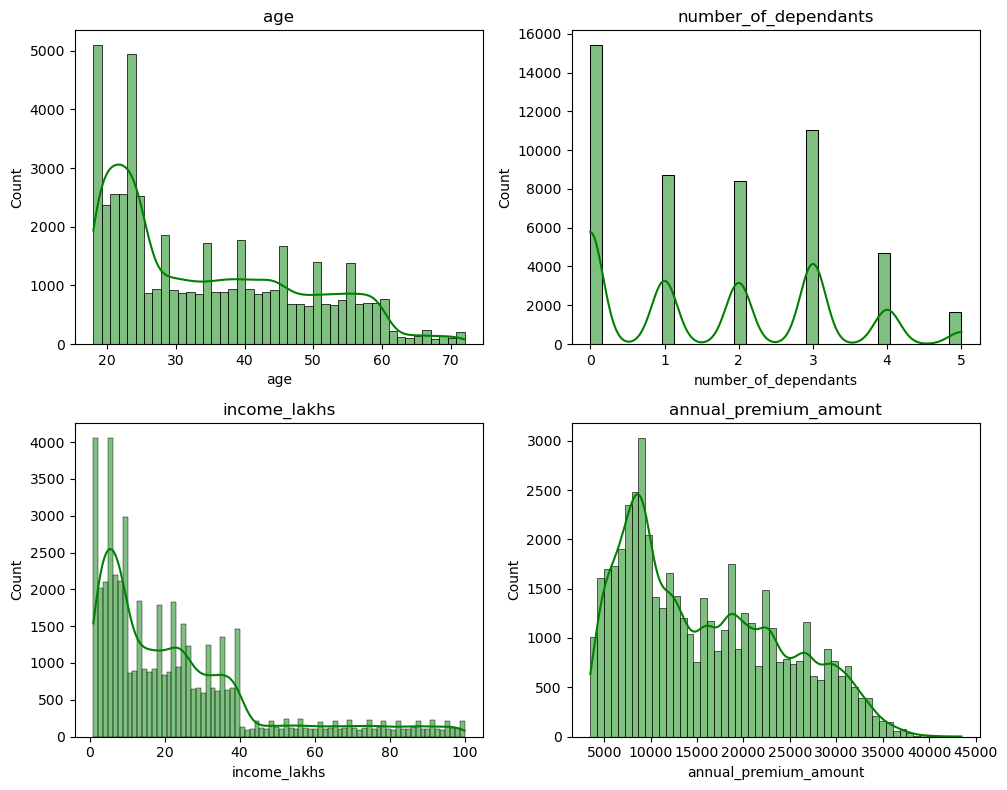

In [26]:
# Assume numeric_columns has 4 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes = axes.flatten()

for ax, col in zip(axes, numeric_columns):
    sns.histplot(df2[col], kde=True, ax=ax, color ='green')
    ax.set_title(col)

plt.tight_layout()
plt.show()

The distribution is right-skewed, with most customers between 20–45 years old. There is a gradual decline as age increases, and very few customers above 60. This indicates a customer base dominated by younger working-age individuals.

The distribution is highly discrete, as expected for a count variable. Most customers have 0 or 1 dependent, with frequencies dropping for higher values. Very few customers report 4 or 5 dependents. This suggests a majority of customers have smaller family sizes.

Most incomes cluster below 20 lakhs. A long tail indicates a smaller group of high-income customers up to ~100 lakhs.
The shape suggests income inequality, with the majority earning on the lower–middle end.

The distribution is again right-skewed, with most premiums between 5,000–15,000. Premium amounts gradually thin out as values approach 40,000+. This suggests the company primarily sells lower to mid-range premium plans, with fewer high-premium customers.

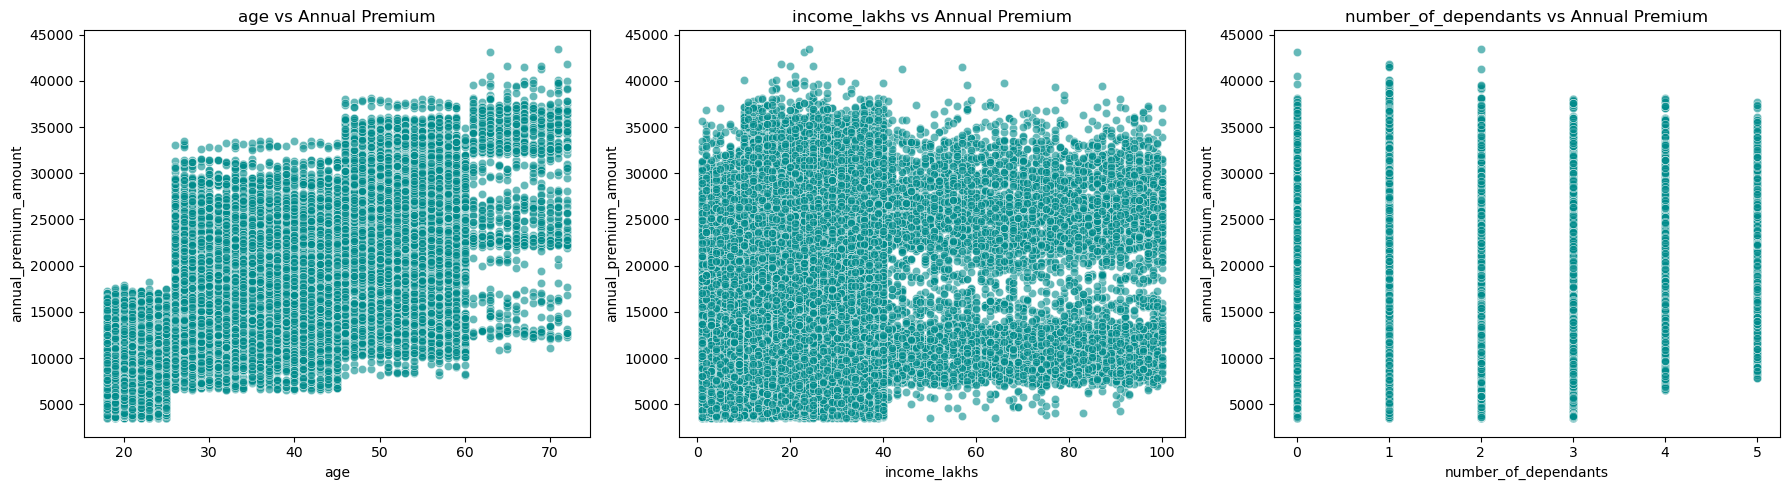

In [27]:
# Getting the scatter plot for age, income_lakhs, number of dependants vs annual premium amount
import matplotlib.pyplot as plt
import seaborn as sns

features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, features):
    sns.scatterplot(data=df2, x=col, y='annual_premium_amount', alpha=0.6, ax=ax, color = 'darkcyan')
    ax.set_title(f'{col} vs Annual Premium')

plt.tight_layout()
plt.show()


Premium amounts are spread across all age groups—from younger (18–30) to older (60+). Slightly higher premiums appear more often among middle-aged customers, but the relationship is weak.

Despite expectations, there is no clear upward trend as income increases.
Customers with both low and high incomes purchase premiums across the full range (₹5,000–₹45,000).

Premium amounts remain widely spread within each dependent category.
No strong pattern: whether someone has 0 dependents or 5, their premium amount is similar.

In [28]:
# getting the subcategories in the different category columns
categorical_cols = df2.select_dtypes(['object']).columns
for col in categorical_cols:
    print(col, df2[col].unique())

gender ['Male' 'Female']
region ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status ['Salaried' 'Self-Employed' 'Freelancer']
income_level ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan ['Bronze' 'Silver' 'Gold']


In [29]:
# Changing the different non-smoking categories to No Smoking 
df2['smoking_status'] = df2['smoking_status'].replace(
    {
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking'
    }
)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [30]:
# getting the gender count
df2['gender'].value_counts()

gender
Male      27431
Female    22477
Name: count, dtype: int64

In [31]:
# percentage count of the gender values
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

In [32]:
# percentage count of the gender count
pct_count.values

array([0.54963132, 0.45036868])

<Axes: xlabel='gender'>

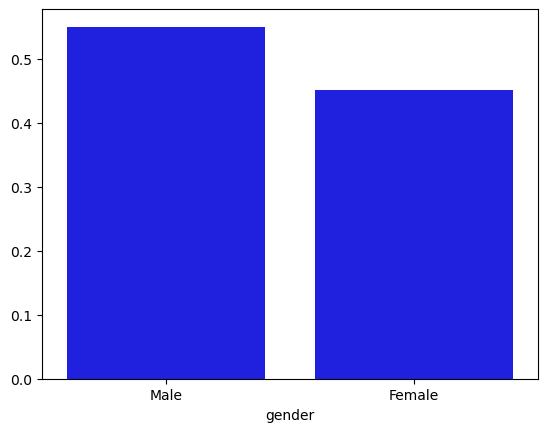

In [33]:
# Bar plotting of the gender percentage count
sns.barplot(x=pct_count.index, y=pct_count.values, color = 'blue')

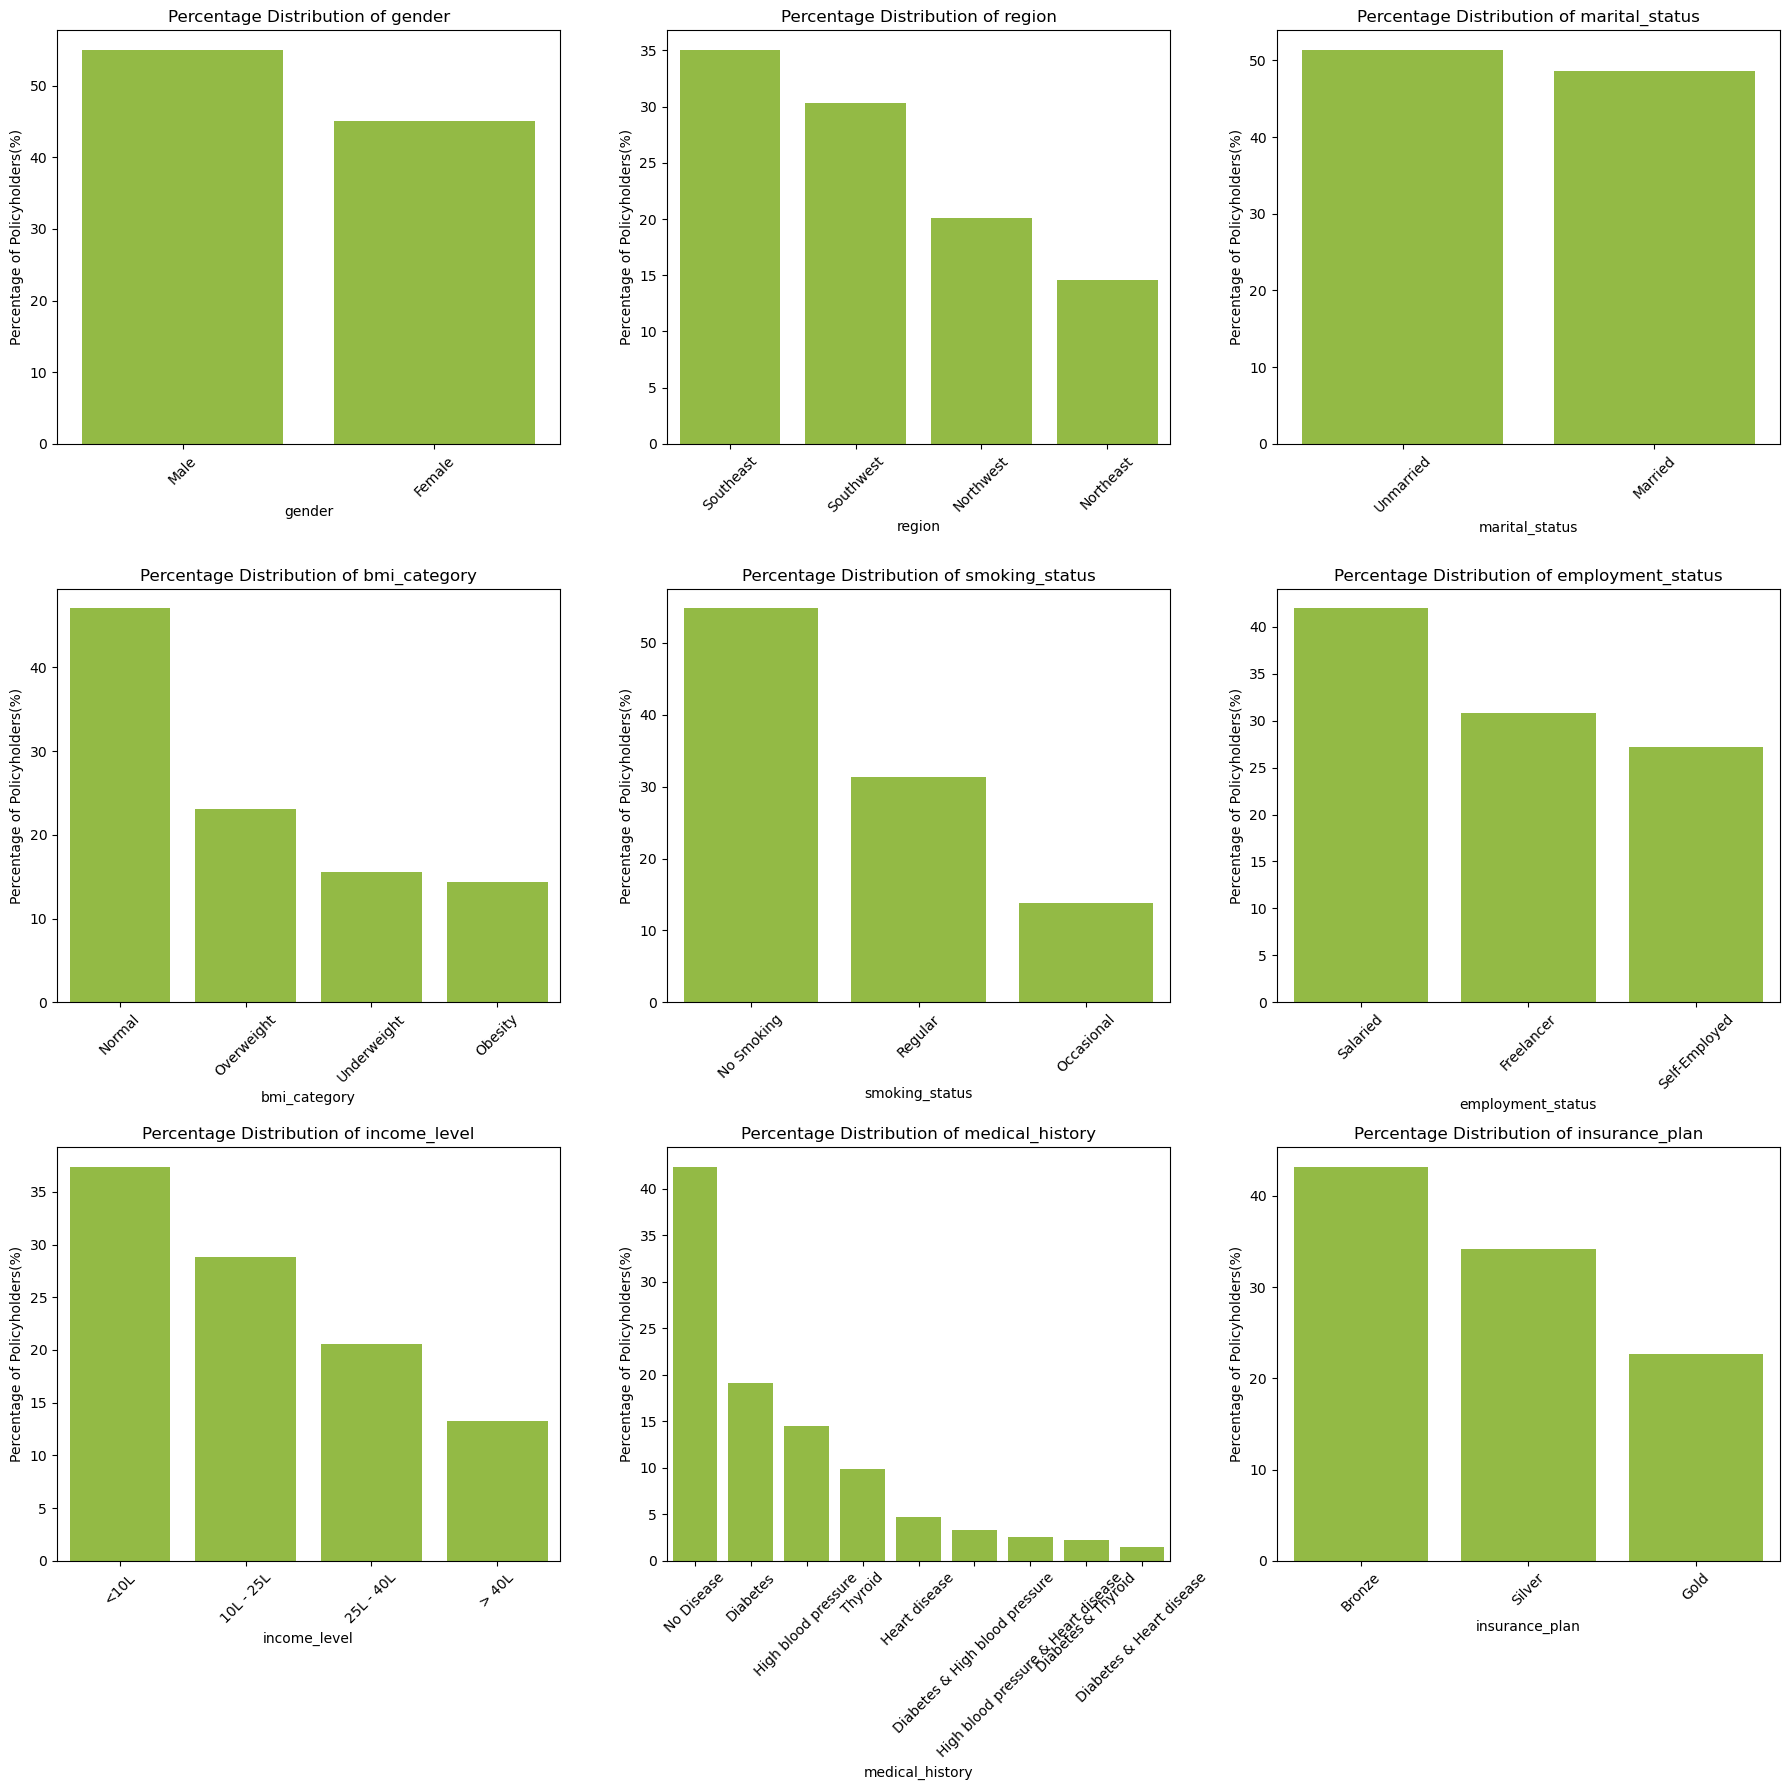

In [34]:
# Plotting pencentage of policy holders w.r.t different categories
fig, axes = plt.subplots(3, 3, figsize=(18,18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True)*100  # normalize =True gives the relation

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, color='yellowgreen')
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders(%)')
    ax.set_label(column)     # Set xlabel to the column name for clarity

    # Rotate labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()   # Adjusts plot parameters for better fit in the figure window
plt.show()


Slightly more males than females. Overall balanced gender mix.

Southwest and Southeast dominate. Fewer customers in Northwest and Northeast.

Married ≈ Unmarried. Balanced distribution across both groups.

Majority are Normal weight. Overweight is the second-largest group. Obese categories small, indicating healthier population.

Most are non-smokers. Moderate number of regular smokers. Few occasional smokers.

Salaried group is the largest. Self-employed and retired make up smaller portions.

Largest group earns < 10L. Middle-income brackets (10–40L) are moderately represented. Very high-income customers are few.

Majority have no disease. Common issues: blood pressure, diabetes, family history.Severe chronic diseases are rare.

Bronze plan is most popular. Silver is second. Gold is least chosen. Thus, customers prefer economical plans.

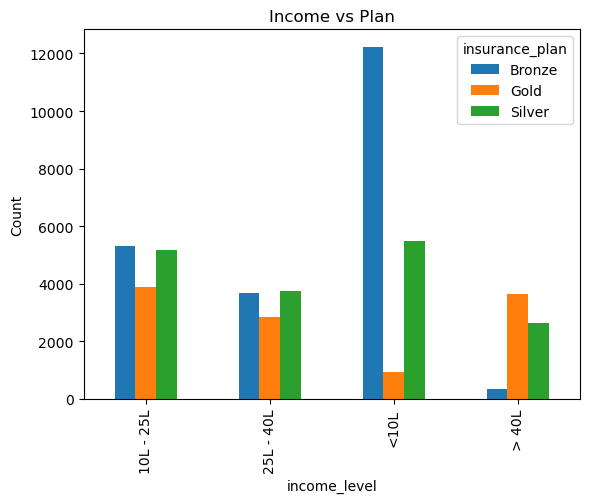

In [35]:
# plotting  the insurance_plan values as per income level
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

As income increases, people are more willing to pay for higher-tier plans.
Lower-income individuals naturally gravitate toward more affordable plans (Bronze).

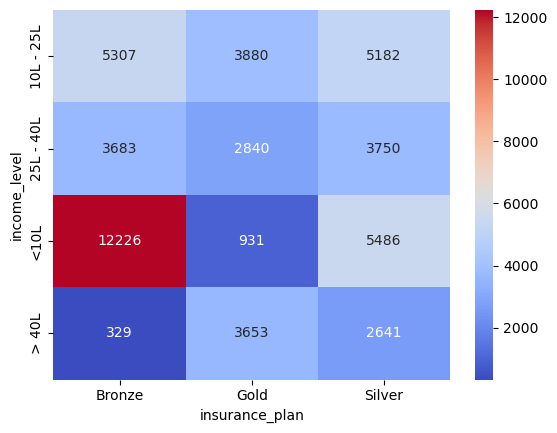

In [36]:
# Corrlation plot of income level and insurance plan
sns.heatmap(crosstab, annot=True, fmt='d', cmap='coolwarm')
plt.show()

The heatmap shows a clear income–plan pattern: low-income customers (<10L) heavily choose Bronze, mid-income groups (10–40L) split across all plans with a slight tilt toward Silver, and high-income customers (>40L) predominantly choose Gold. Overall, higher income leads to higher-tier plan selection.

In [37]:
# Checking the data
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [38]:
# Getting the different categories of medical history
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [39]:
# Adding the risk score  for differenct medical category
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

# Split medical_history into two columns
df2[['disease1', 'disease2']] = (
    df2['medical_history']
    .str.lower()               # convert entire string to lowercase
    .str.split("&", expand=True)
)

# Replace missing diseases with 'none'
df2['disease1'] = df2['disease1'].fillna('none').str.strip()
df2['disease2'] = df2['disease2'].fillna('none').str.strip()

df2.head()


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none


In [40]:
# Fill missing disease values
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

# Initialize total score
df2['total_risk_score'] = 0

# Add scores for each disease
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += (
        df2[disease].map(risk_scores).fillna(0)
    )

# Normalize the risk score
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

if max_score != min_score:
    df2['normalized_risk_score'] = (
        (df2['total_risk_score'] - min_score) /
        (max_score - min_score)
    )
else:
    df2['normalized_risk_score'] = 0   # All scores identical → normalized = 0

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [41]:
# Getting the insurance plan calegory
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [42]:
# Mapping the Insurance Plan
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [43]:
# Mapping the Income Level
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [44]:
# Getting dummies for nominal value columns
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first =True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [45]:
# Dropping the columns
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


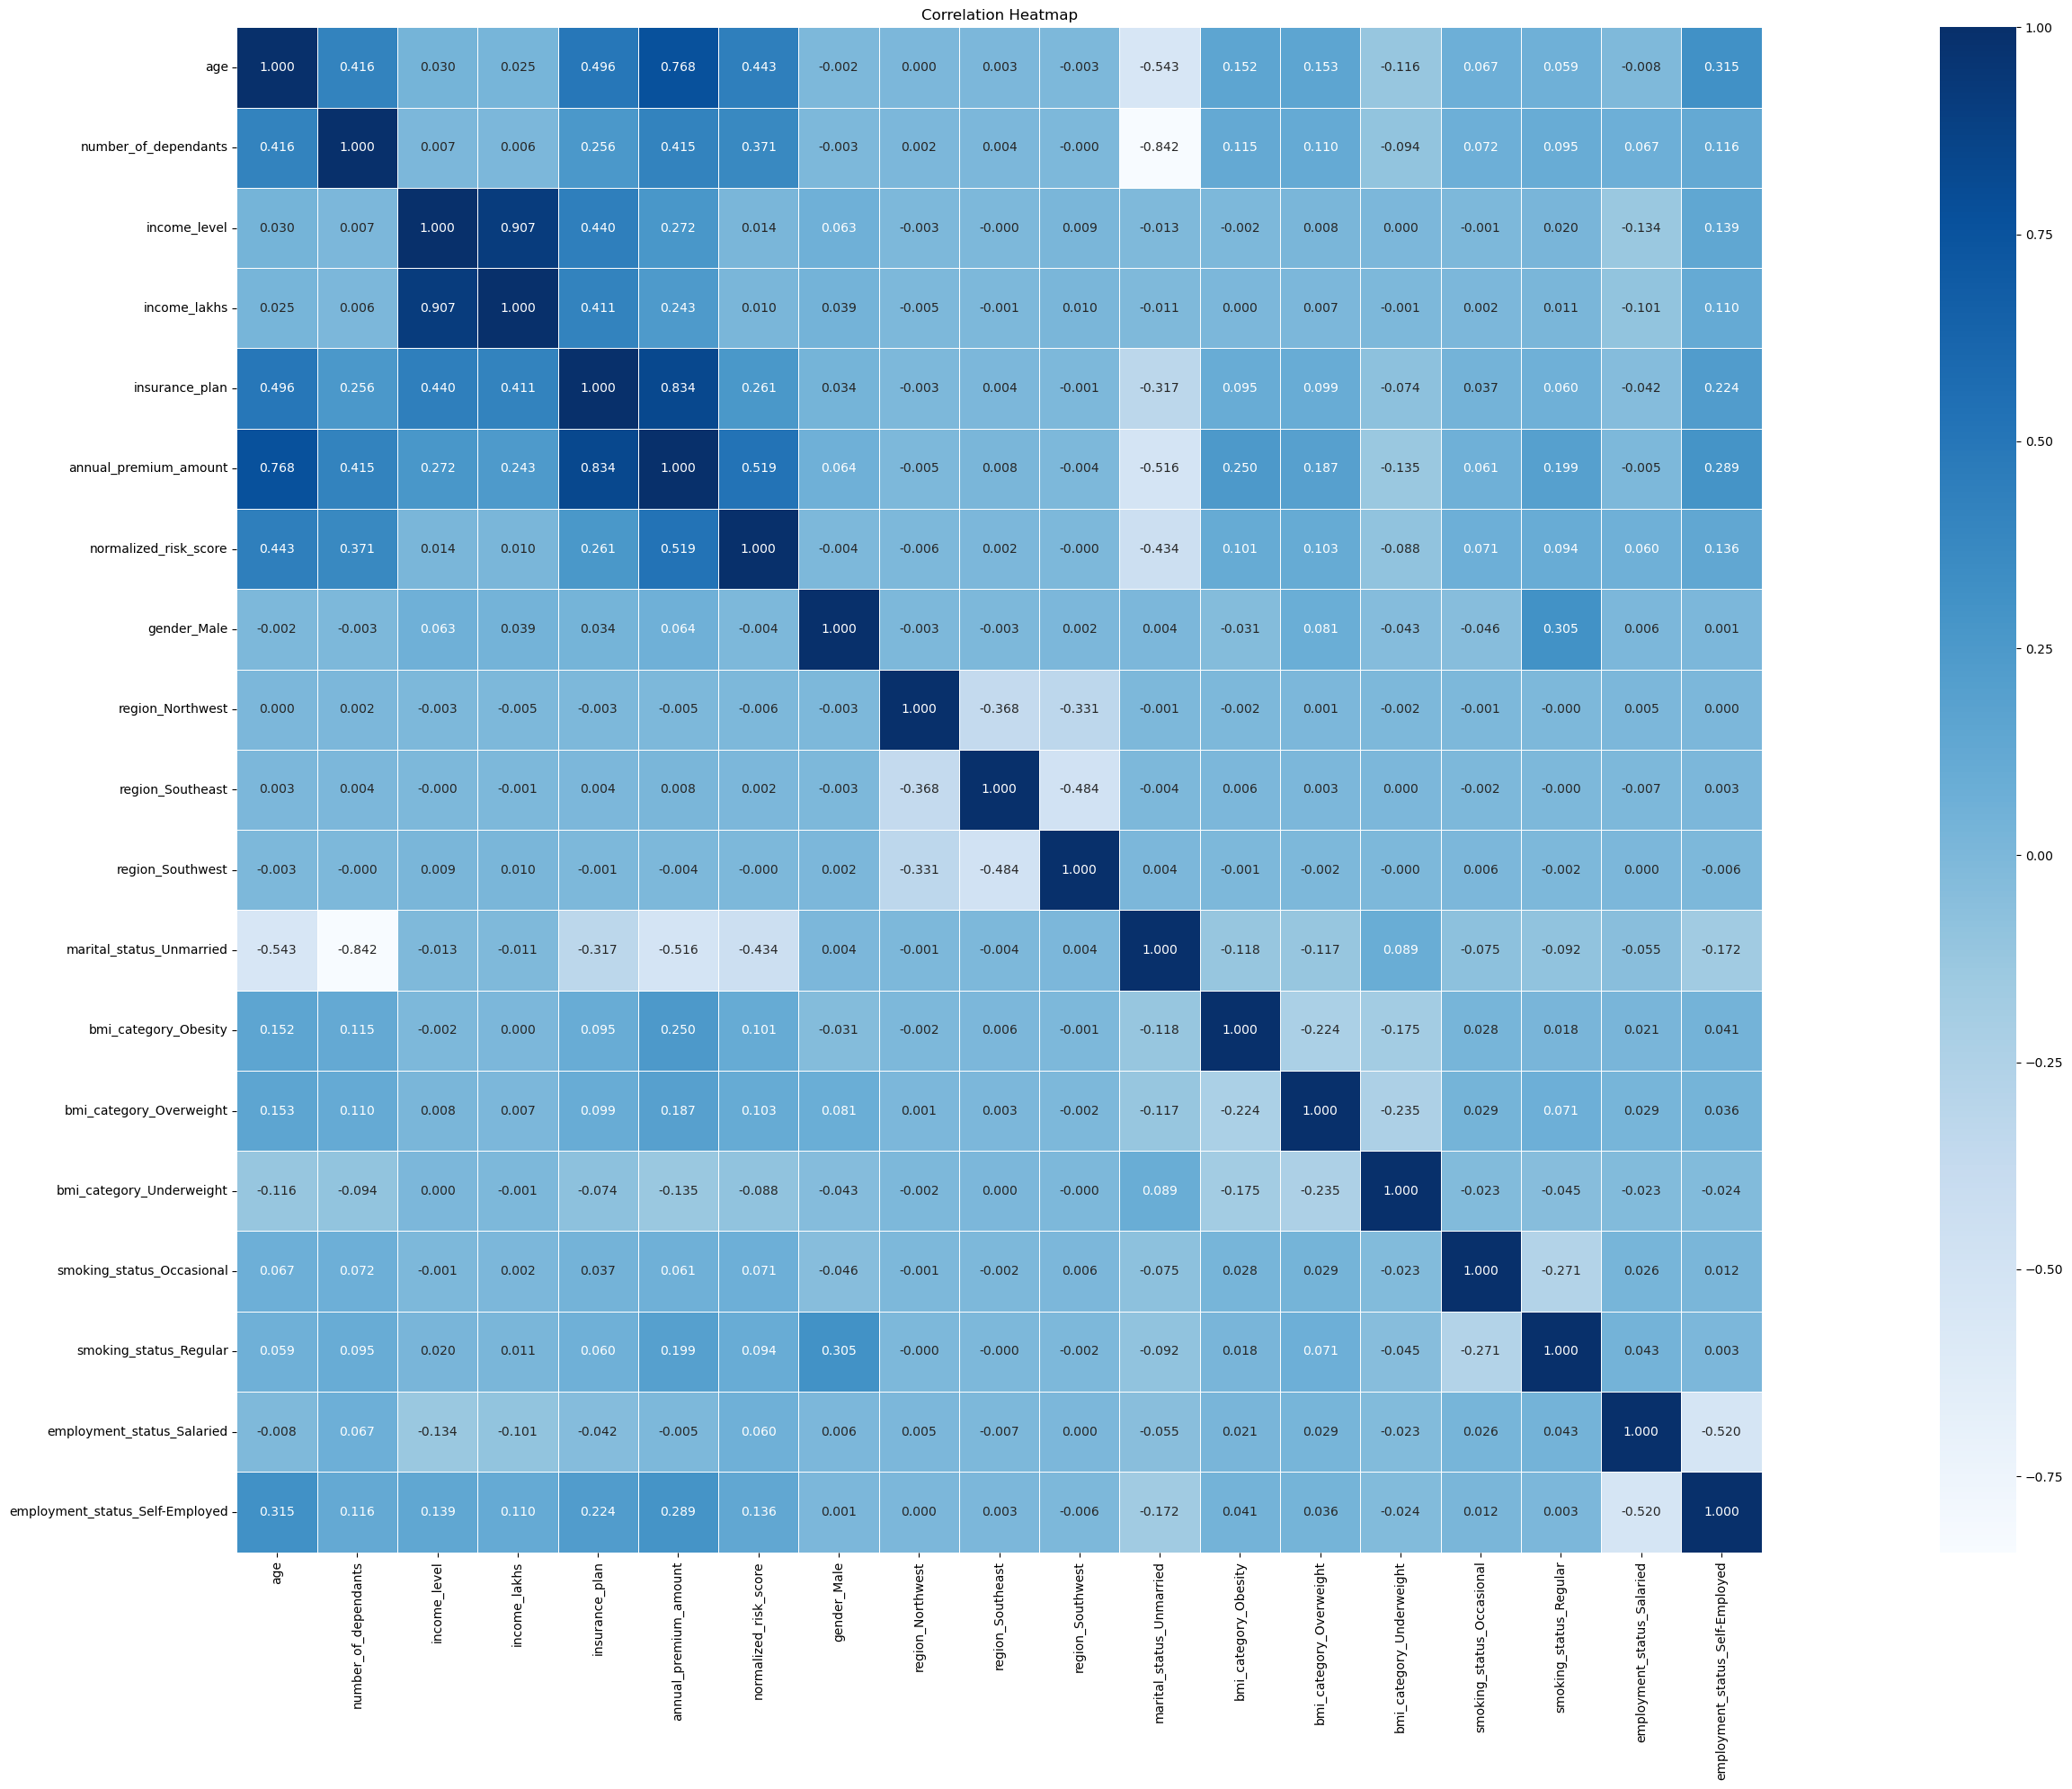

In [46]:
# Select only numeric columns for correlation
corr_matrix = df4.corr()

# Set up the matplotlib figure
plt.figure(figsize=(40, 20))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".3f", linewidths=0.5, square=True)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

The heatmap shows Age, annual premium amount, and normalized risk score have strong positive correlations, meaning they tend to increase together. Income variables are also highly correlated with each other, which is expected. One-hot encoded categories (BMI, smoking status, region, employment) show negative correlations within their groups because only one category can be true at a time. Overall, no unexpected or problematic correlations appear outside these natural relationships.

In [47]:
# Scalling the necessary columns 
X = df4.drop('annual_premium_amount', axis='columns')
y= df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants','income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [48]:
# Getting the more information
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
# Calculate the Vif score
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [50]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


The VIF table checks multicollinearity among your model’s features. Most variables have acceptable VIF values (below 5), indicating low to moderate correlation. However, income_level and income_lakhs have very high VIF (>10), showing severe multicollinearity.

In [51]:
# Dropping the income_level
calculate_vif(X.drop('income_level', axis ='columns'))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


On dropping the income level, the VIF values are within acceptable limit.

In [52]:
# dropping the income level
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## Model Training

In [53]:
# Importing the necessary library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', y_test.shape)

X_train: (34935, 17)
X_test: (14973, 17)
y_train: (34935, 17)
y_test: (14973,)


### Using Linear Regression

In [54]:
# fitting the model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.928214357691676, 0.9280547230217836)

In [55]:
# making the prediction
y_preds = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_preds)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE:", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE: 5165611.9130279925 RMSE:  2272.7982561212934


In [56]:
# model coeficients
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [57]:
# X_test columns
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [58]:
# creating a dataframe for coefficient
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df

,Coefficients
age,11160.926462
number_of_dependants,-676.443991
income_lakhs,-514.229816
insurance_plan,12557.012936
normalized_risk_score,4810.357702
gender_Male,168.646662
region_Northwest,-35.719292
region_Southeast,39.965130
region_Southwest,-24.652929
marital_status_Unmarried,-935.760611


In [59]:
# sorting the feature importance
coef_df = coef_df.sort_values(by = 'Coefficients', ascending=True)
coef_df

,Coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


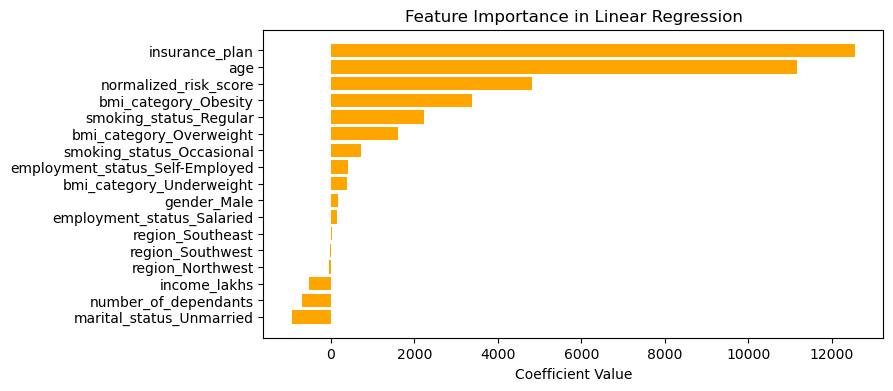

In [60]:
# Plotting the feature importance values
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='orange')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

The chart shows which features most strongly influence the linear regression model’s predictions. Insurance plan and age are the biggest contributors, meaning they heavily affect the output. Factors like risk score, obesity, and regular smoking also increase predicted values. Features such as region, gender, and employment status have very little impact.

## Using Ridge model

In [61]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

## Using XGBoost Regressor

In [62]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9860964417457581, 0.9809534549713135)

In [63]:
# Making prediction
y_preds = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_preds)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE: ", rmse_xgb)

XGBoost Regression ==> MSE: 1367525.6922808294 RMSE:  1169.412541527082


It is evident that XGBoost gives the best score.

## Randomized SearchCV

In [64]:
# Using Randomized SearchCV
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9809474547704061

In [65]:
# Finding best parameters
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [66]:
# Best model
best_model = random_search.best_estimator_

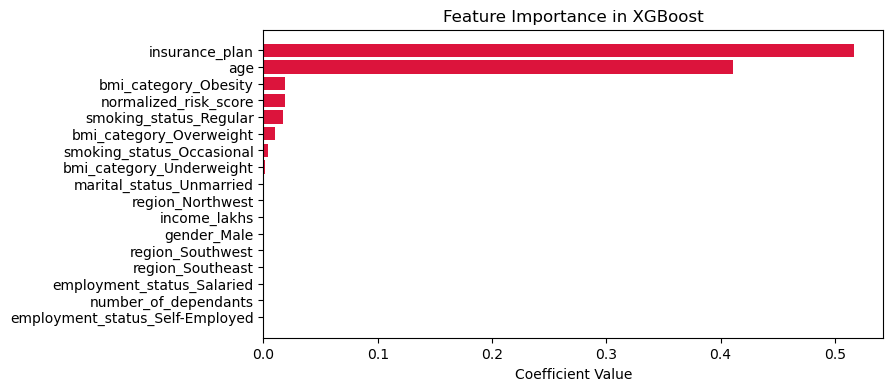

In [67]:
# Plotting the feature importances for XGBoost
feature_importances = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='crimson')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

The chart shows that the XGBoost model relies heavily on insurance_plan and age, which dominate all other features in importance. BMI-related categories, smoking status, and risk score contribute moderately but far less. Most other features—like income, region, and marital status—have minimal impact. Overall, the model’s predictions are driven mainly by just a few strong predictors.

### Error Analysis

In [68]:
# Conducting  Error Analysis
y_preds = best_model.predict(X_test)

residuals = y_preds - y_test
residuals_pct = residuals*100/ y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_preds,
    'diff' : residuals,
    'diff_pct': residuals_pct

})
results_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

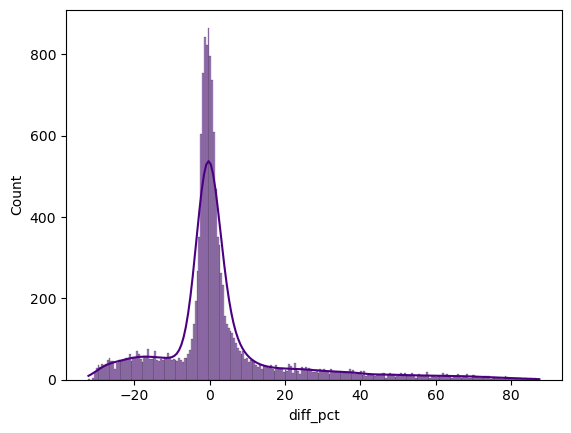

In [69]:
# Plotting the error percentage
sns.histplot(results_df['diff_pct'], kde=True, color='indigo')

The histogram shows the distribution of the error percentage (diff_pct). Most errors cluster tightly around 0%, meaning predictions are usually accurate. The long right tail shows occasional large overestimates, in many cases the difference is very high while the left tail shows some underestimates. Overall, the right tail pct_diff is really worrying and need to be addressed.

In [70]:
# Finding the rows where diff_pct greater than extreme error threshold
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4487, 4)

So, there are 4487 rows having greater pct_diff than the threshold value

In [71]:
# Finding extreme_errors_pct
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

29.967274427302478

So, about 30% of the rows have greater pct_diff than the threshold value

In [72]:
# Finding the rows where Difference_pct > 50 percentage
results_df[np.abs(results_df.diff_pct)>50]

,actual,predicted,diff,diff_pct
11513,4277,6565.852051,2288.852051,53.515362
9027,3868,6565.852051,2697.852051,69.747985
37298,4077,6942.343750,2865.343750,70.280690
7174,4349,6565.852051,2216.852051,50.973834
42834,3702,6565.852051,2863.852051,77.359591
...,...,...,...,...
25427,3783,6565.852051,2782.852051,73.562042
2612,3727,6670.849121,2943.849121,78.987097
32450,3926,6565.852051,2639.852051,67.240246
21184,4330,6820.886230,2490.886230,57.526241


In [73]:
# Sorting the diff_pct values
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
36269,3501,6565.852051,3064.852051,87.542189
48801,3516,6565.852051,3049.852051,86.742095
42342,3521,6565.852051,3044.852051,86.476911
18564,3523,6565.852051,3042.852051,86.371049
7988,3527,6565.852051,3038.852051,86.159684
...,...,...,...,...
32671,4656,6994.980957,2338.980957,50.235845
14798,4371,6565.852051,2194.852051,50.213957
13736,4371,6565.852051,2194.852051,50.213957
10107,4710,7073.240723,2363.240723,50.174962


In [74]:
# Getting the index value
X_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [75]:
# finding extreme results index
extreme_results_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [76]:
# extreme errors data
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


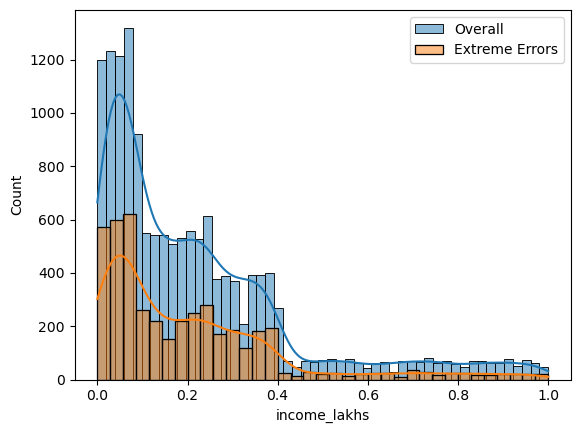

In [77]:
# plotting overall and extreme errors
sns.histplot(X_test.income_lakhs, label = "Overall", kde=True)
sns.histplot(extreme_errors_df.income_lakhs, label = "Extreme Errors", kde=True)
plt.legend()
plt.show()

The plot compares the distribution of income_lakhs for the full test set (blue) versus the subset of extreme-error cases (orange).
Both histograms show that incomes are heavily concentrated at the lower end, but extreme-error cases appear more frequent there.
The KDE curves highlight that extreme errors occur disproportionately in lower-income ranges.

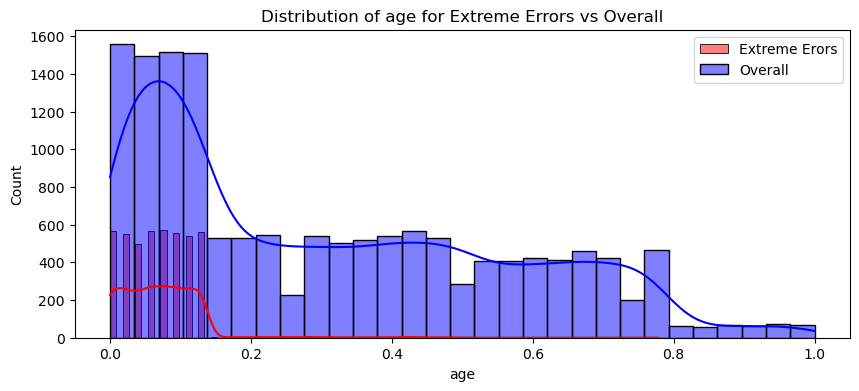

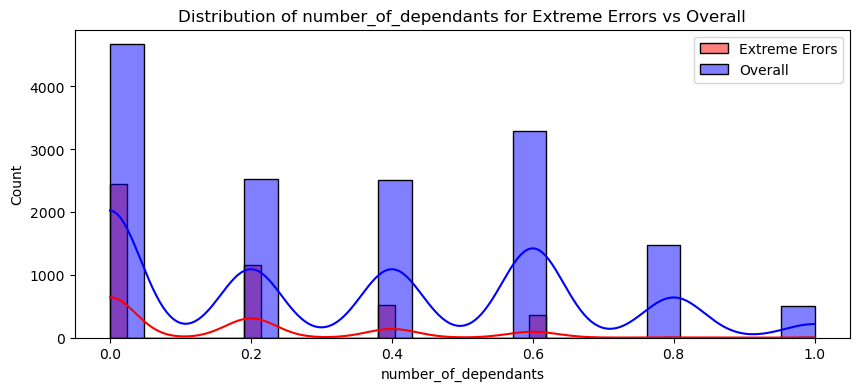

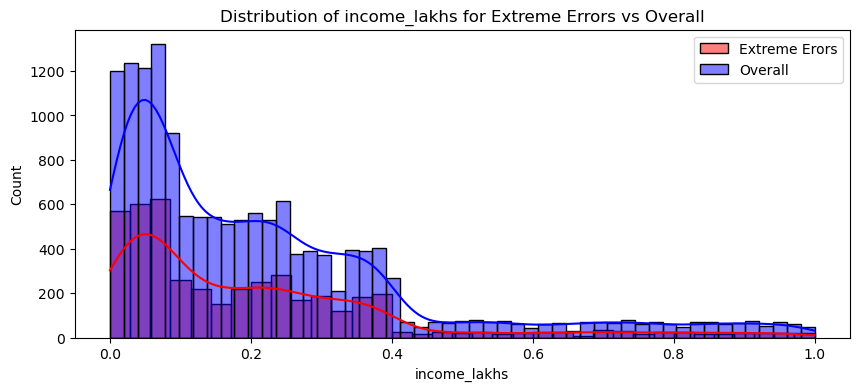

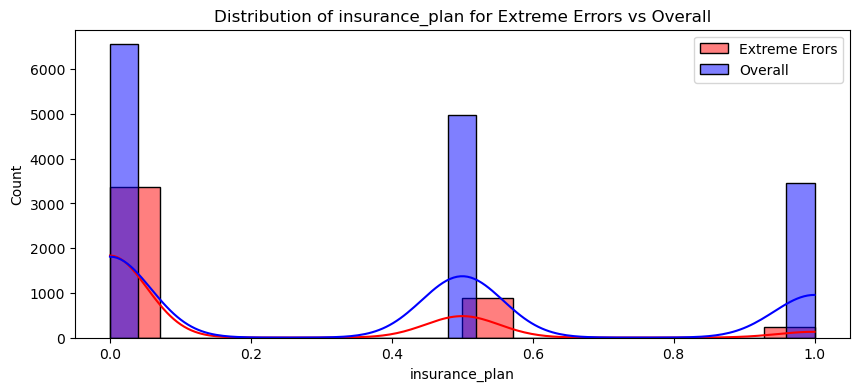

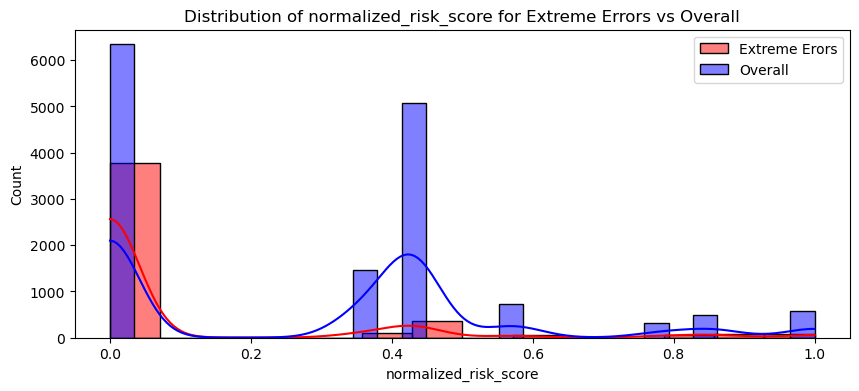

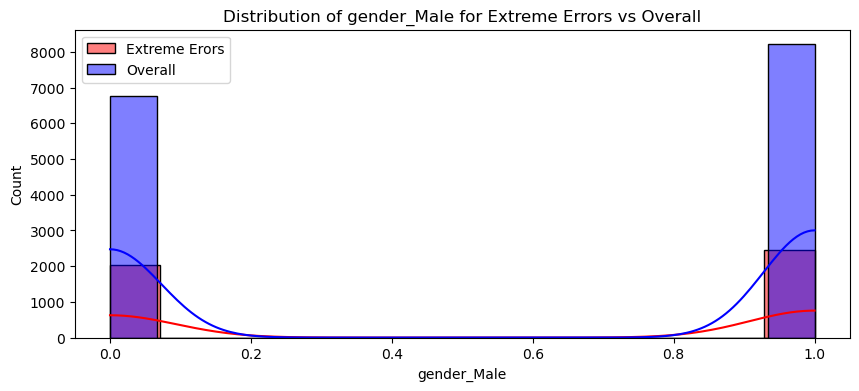

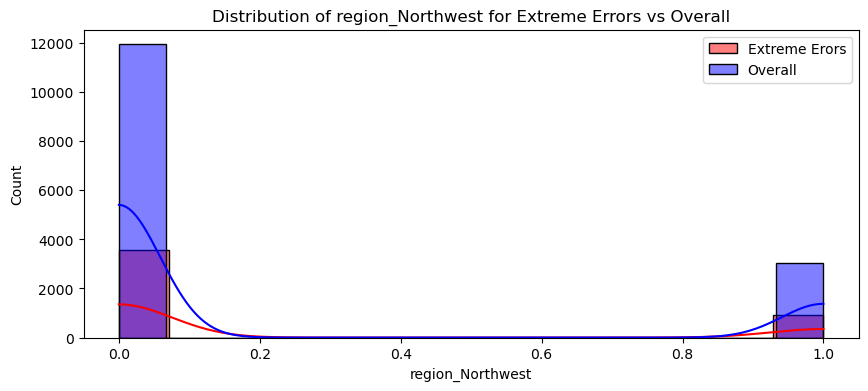

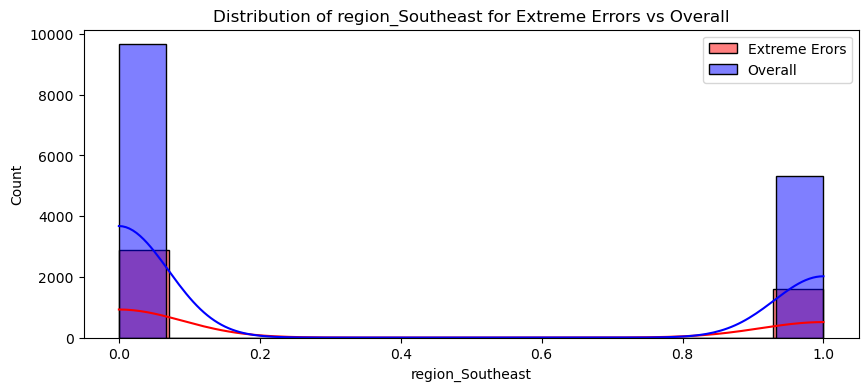

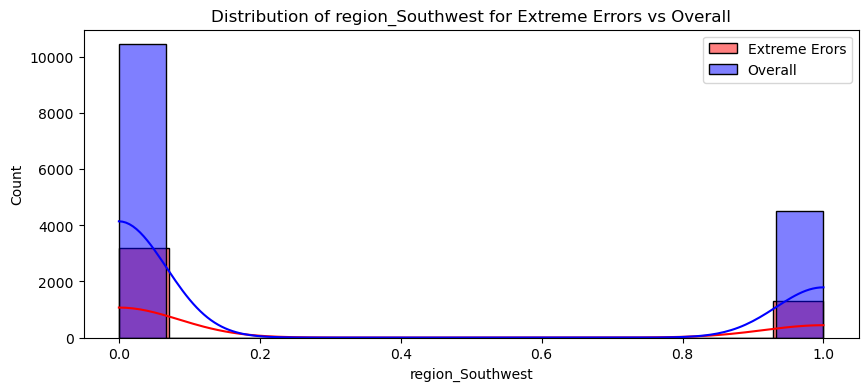

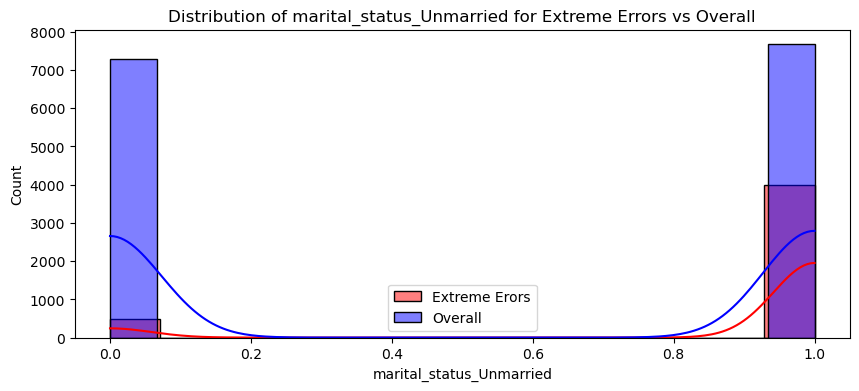

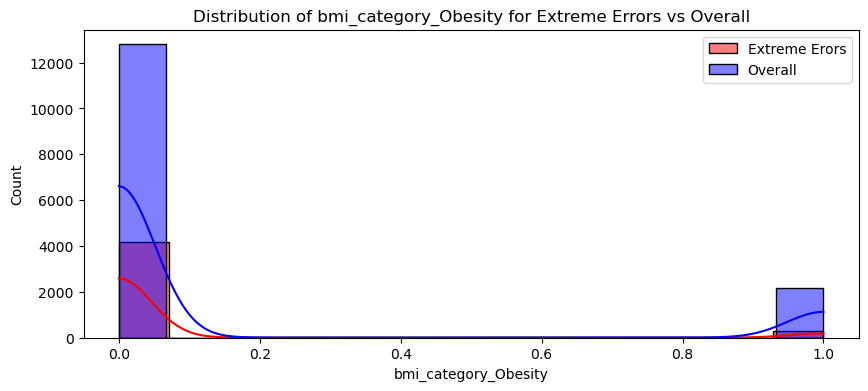

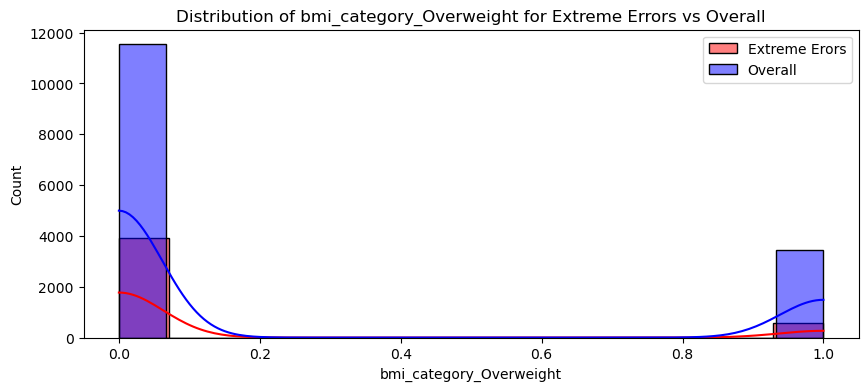

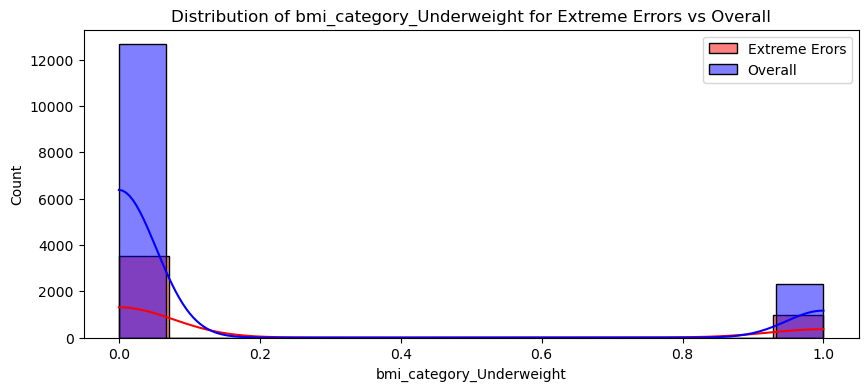

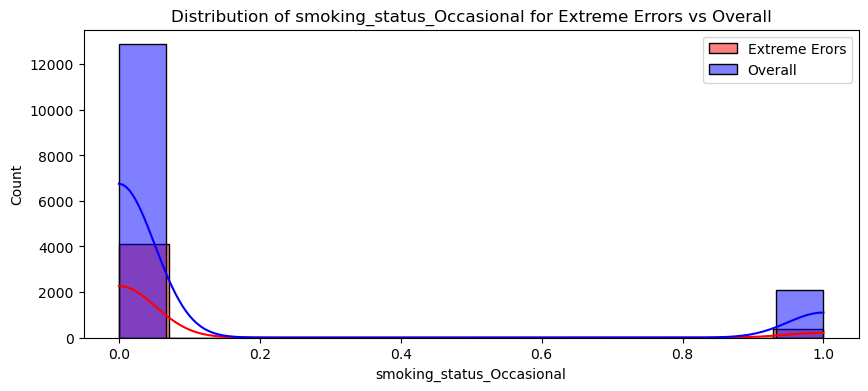

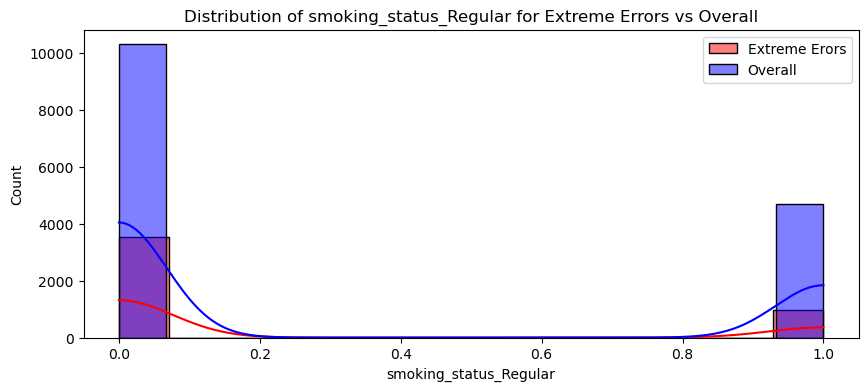

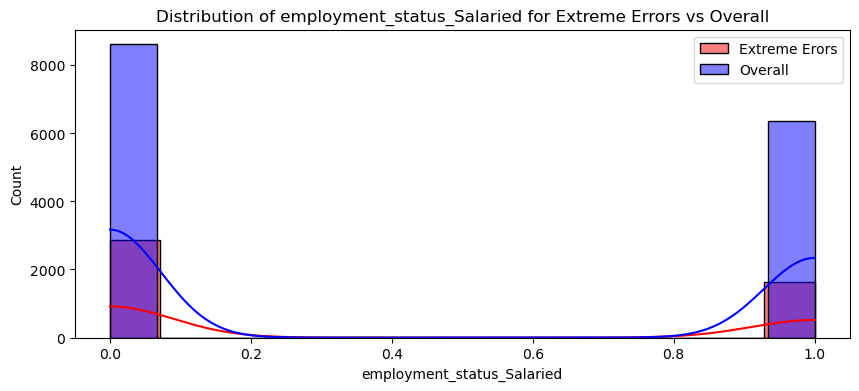

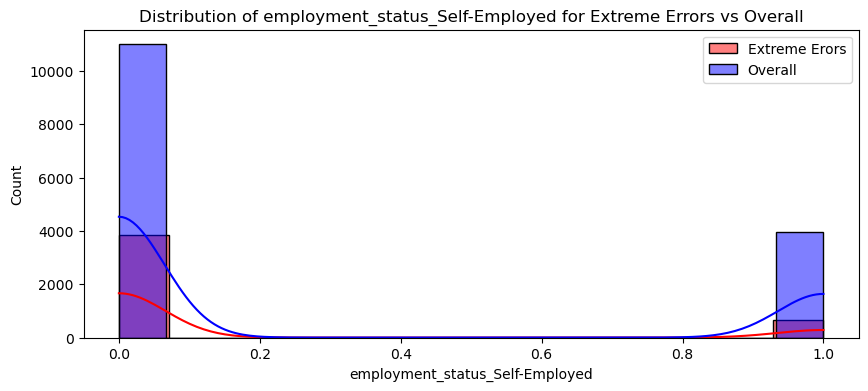

In [78]:
# Plot of extreme errors and overall errors as per different column values
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[feature], color='red', label ='Extreme Erors', kde= True)
    sns.histplot(X_test[feature], color='blue', label ='Overall', alpha =0.5, kde= True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

It is evident that the extreme errors are centered in the lower age group

In [79]:
# columns to scale
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [80]:
extreme_errors_df['income_level']=-1

In [81]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale]=scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


In [82]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4487.000000,4487.000000,4487.0,4487.000000,4487.000000
mean,21.804992,0.739247,-2.0,21.182527,1.302429
std,3.172355,0.968855,0.0,20.598596,0.563135
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

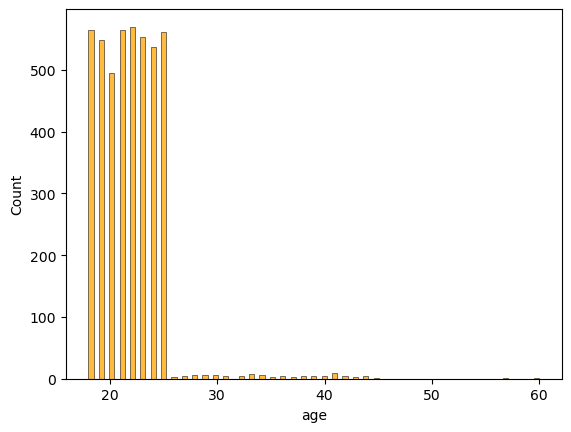

In [83]:
sns.histplot(df_reversed['age'], color='orange')

In [84]:
df_reversed['age'].quantile(0.97)

25.0

## Summary
This analysis identified age, insurance plan type, medical risk score, BMI category, and smoking status as the primary drivers of health insurance premium amounts, while demographic and regional variables showed limited influence. Among the evaluated models, XGBoost delivered the highest predictive performance, significantly outperforming linear and ridge regression approaches.

However, detailed error analysis revealed that the largest prediction errors are concentrated among younger policy holders, particularly those aged 25 and below. Nearly all extreme percentage errors occurred within this age group, indicating that a single global model struggles to capture pricing dynamics for younger customers. To address this limitation, the dataset will be segmented into two groups: individuals aged ≤ 25 (hpp_young) and individuals aged > 25 (hpp_adult). This targeted modeling approach is expected to reduce percentage errors, improve predictive accuracy, and provide more nuanced insights into age-specific premium behavior.

Overall, the findings highlight the importance of combining robust preprocessing, model selection, and segmentation strategies to build reliable, business-ready insurance pricing models.